In [1]:
import sqlite3
import pickle
import pandas  as pd
import numpy   as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
from matplotlib import pyplot as plt
from xgboost import plot_importance

In [3]:
from sklearn.model_selection import RandomizedSearchCV

In [4]:
conn = sqlite3.connect('db\cian.db') 
          
df = pd.read_sql_query ('''
                               SELECT *
                               FROM analytical_base_table
                               ''', conn)

In [5]:
# создание выходной (целевой) переменной
y = df.price
# создание входных переменных
X = df.drop('price', axis = 1)
# разбиение выбоки на тренировочную и тестовую в пропорции 80/20
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

In [6]:
regressor=XGBRegressor(eval_metric='mae', early_stopping_rounds=100)

In [7]:
grid = {'max_depth':    [4, 5, 6],
              'n_estimators': [200, 500, 700],
              'learning_rate': [0.01, 0.02, 0.1, 0,2]}

In [8]:
# подбор гиперпараметров при помощи Random Search
search = RandomizedSearchCV(regressor, param_distributions=grid, n_iter=5, n_jobs=-1, cv=3, verbose=5, return_train_score=True)
search.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[0]	validation_0-mae:28555080.44778
[1]	validation_0-mae:25704472.91167
[2]	validation_0-mae:23139258.96617
[3]	validation_0-mae:20837805.31761
[4]	validation_0-mae:18796679.71728
[5]	validation_0-mae:16980476.38710
[6]	validation_0-mae:15419316.07650
[7]	validation_0-mae:14055968.96184
[8]	validation_0-mae:12874323.02758
[9]	validation_0-mae:11897399.77346
[10]	validation_0-mae:11062292.61367
[11]	validation_0-mae:10388499.47415
[12]	validation_0-mae:9831485.57602
[13]	validation_0-mae:9372404.53526
[14]	validation_0-mae:9012507.35573
[15]	validation_0-mae:8716206.77791
[16]	validation_0-mae:8462659.30125
[17]	validation_0-mae:8286685.29282
[18]	validation_0-mae:8121326.14610
[19]	validation_0-mae:7989031.92054
[20]	validation_0-mae:7858748.68662
[21]	validation_0-mae:7763942.04904
[22]	validation_0-mae:7691809.98598
[23]	validation_0-mae:7627662.30570
[24]	validation_0-mae:7569890.57530
[25]	validation_0-mae:7519496.60928
[2

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=100,
                                          enable_categorical=False,
                                          eval_metric='mae', feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.02, 0.1, 0,
                                                          2],
                                        'max_depth': [4, 5, 6],
                                        'n_estimators': [200, 500, 700]},
                   return_train_score=True, verbose=5)

In [9]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", search.best_estimator_)
print("\n The best score across ALL searched params:\n", search.best_score_)
print("\n The best parameters across ALL searched params:\n", search.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

 The best score across ALL searched params:
 0.8831541103434213

 The best parameters across ALL searched params:
 {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.1}


In [10]:
model_xgb=XGBRegressor(learning_rate=search.best_params_["learning_rate"],
                           n_estimators=search.best_params_["n_estimators"],
                           max_depth=search.best_params_["max_depth"],
                           eval_metric='mae')

model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [11]:
pred = model_xgb.predict(X_valid)

In [12]:
print('R^2:', r2_score(y_valid, pred))
print('MAE: ', mean_absolute_error(y_valid, pred))

R^2: 0.8988431839824397
MAE:  5244442.101751136


Лучшая модель XGBoost с гиперпараметрами n_estimators=700, max_depth=5, learning_rate=0.1 показала большую эффективность по сравнению с моделью градиентного бустинга из sklearn, но не достигла точности ранее обученной модели Random Forest (R^2: 0.90, MAE:  4701742).

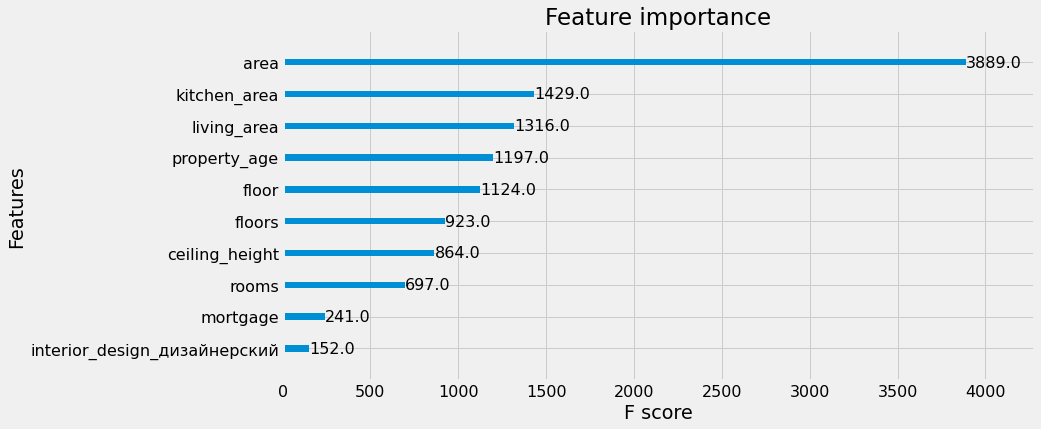

In [20]:
# важность признаков
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(model_xgb, max_num_features=10, ax=ax)
plt.show()

In [21]:
# сохранение модели
with open('fitted_models/xgboost.pkl', 'wb') as f:
    pickle.dump(model_xgb, f)